# Linebackers - Spin to Win!

The best introduction we find to the role of a linebacker is that they are a quarterback of the defense line. A perfect linebacker has to be jack of all trades, has high game intelligence, be agile, swift, big but not too big. A good linebacker is a backbone of defense and it is usually one of the most valuable defense players. There are three linebackers in the top 5 defensive players ranked by salary in NFL 2022.

![spin](https://media.tenor.com/nnhFRQSsvskAAAAC/ballet-dance.gif "spinning")



In our work we try to answer the question:

**What makes the best linebackers the best?**

If one asks a scout - game IQ (vision, recognition) comes first, but it is not the focus of our research here. And so is it - size (`weight`, `height`), `speed`, `acceleration`? Maybe something else? 
    - **Rotation**: ability to move quickly around yourself, squeeze through tight offensive lines dodging grabs and blocks
    - **Change of direction**: ability to change direction of movement, zig-zag movements like a cone-drill

* While speed and acceleration are well studied, ability to change direction / rotational movements are not so much:
    * LB can move in a straight line or zig-zag around, fool linemen with their quick footwork effectively getting to the ball, stopping the offensive play. We believe that it should make a difference and one's ability to move their feet quickly should be seen in the performance.

**To illustrate our reasoning - here is the movement graph of a quarterback sack.**
<br>*The blue dots are the player's position on the field. Black lines indicate where they are facing, the length of the line indicates speed.*

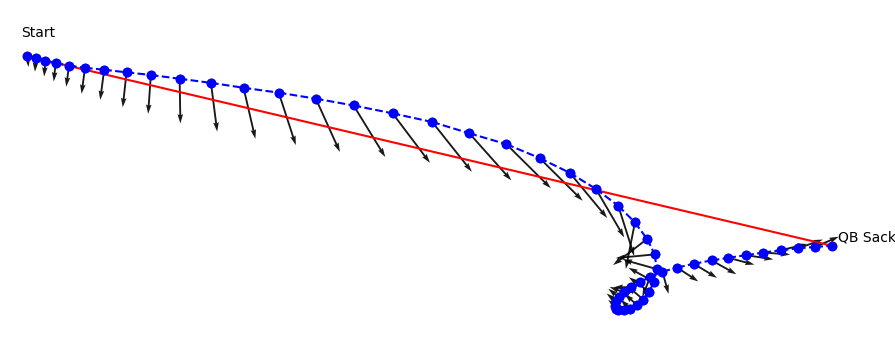



One can recognize S.Barrett's play vs Miami Dolphins quarterback: [youtube video](https://youtu.be/HtUr_MW83sA?t=85) 



**Methodology: defining a successful play**:
* We look at the first 8 weeks of data of the NFL 2021-22 season and extract data from all pass rushes plays by linebackers.
* As an individual performance measure, methodology implies that a pass rush is successful if that player completes a quarterback sack, hit or hurry and fails otherwise.


**What do we do?**
1. *Load data, EDA*:  look at linebackers and number of sacks, hits and hurries. Try to define the most successful players.
2. *Form stats, metrics*: extract relevant data from frame by frame plays. Introduce new metrics to measure performance
3. *Study qb sacks:* take a closer look at qb sacks as one of the most valuable linebacker's plays. 
4. *Cross-data analysis:* What are the defining characteristics of a successful play?
5. *Cross-player analysis:* what makes the best players the best?
6. *Form the results*
 
   
**Summary of the results - *Spin to win!***

    
*  We found statistical evidence that in order to complete a successful pass rush a linebacker needs to move faster, rotate more, be able to change direction more:
    * During a sack, for example, linebackers on average both **rotate**  and **change direction** about full circle in total         
* From player specific data we found that **the best linebackers** are the ones who are able to generate enough momentum (*force* defined as a product of `weight` and `acceleration`) as well as demonstrating better `rotational movements` than their colleagues in this position.


**Applications and further research**:
* Coaches might want to include more exercise involving spinning and rotating to their drills
* Scouts are already look at the the bigger players but now they might also want to see how quick one on their feet and able to move through offense demonstrating rotation movements
* Further research might include a larger database to incorporate more data on sacks, hits and hurries. Also similar research could be done for different types of positions


# EDA

### Loading the data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import math
import random

from pandas_profiling import ProfileReport
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from random import sample

pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

In [3]:
df_games = pd.read_csv('games.csv')
df_plays = pd.read_csv('plays.csv')
df_players = pd.read_csv('players.csv')
df_scouting = pd.read_csv('pffScoutingData.csv')
df_week_1 = pd.read_csv('week1.csv')
df_week_2 = pd.read_csv('week2.csv')
df_week_3 = pd.read_csv('week3.csv')
df_week_4 = pd.read_csv('week4.csv')
df_week_5 = pd.read_csv('week5.csv')
df_week_6 = pd.read_csv('week6.csv')
df_week_7 = pd.read_csv('week7.csv')
df_week_8 = pd.read_csv('week8.csv')

In [4]:
data_week = [
    df_week_1,
    df_week_2,
    df_week_3,
    df_week_4,
    df_week_5,
    df_week_6,
    df_week_7,
    df_week_8]

df_week = pd.concat(data_week)
df_week.time = pd.to_datetime(df_week.time)

In [5]:
#making snake case
pattern = re.compile(r'(?<!^)(?=[A-Z])')

data_list = [
    df_games,
    df_plays,
    df_players,
    df_scouting,
    df_week_1,
    df_week_2,
    df_week_3,
    df_week_4,
    df_week_5,
    df_week_6,
    df_week_7,
    df_week_8,
    df_week]

for data in data_list:
    data.columns = list(pattern.sub('_', col).lower() for col in list(data.columns))

### Closer look at linebackers

* We are interested in the following players' positions:
    1. LB - linebacker
    2. OLB - outside linebacker
    3. ILB - inside linebacker
    4. MLB - middle linebacker

In [17]:
lb = ['LB', 'OLB', 'ILB', 'MLB']
df_players_lb = df_players.loc[df_players['official_position'].isin(lb)]
df_players_lb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 36 to 1665
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   nfl_id             246 non-null    int64 
 1   height             246 non-null    object
 2   weight             246 non-null    int64 
 3   birth_date         207 non-null    object
 4   college_name       208 non-null    object
 5   official_position  246 non-null    object
 6   display_name       246 non-null    object
dtypes: int64(2), object(5)
memory usage: 15.4+ KB


* We have 246 players of LB position in the dataset, let's take a closer look

In [18]:
# converting birth_date to age
df_players_lb.loc[:,'birth_date'] = pd.to_datetime(df_players_lb.birth_date)
season_end = pd.to_datetime('2022-01-07')
df_players_lb['age'] = (season_end - df_players_lb.loc[:,'birth_date']) / np.timedelta64(1, 'Y')

df_players.loc[:,'birth_date'] = pd.to_datetime(df_players.birth_date)
season_end = pd.to_datetime('2022-01-07')
df_players['age'] = (season_end - df_players.loc[:,'birth_date']) / np.timedelta64(1, 'Y')

#converting height to foot
def height_foot(h):
    return int(re.findall(r'\d+',h)[0]) + int(re.findall(r'\d+',h)[1]) / 12


df_players['height'] = df_players.height.apply(lambda x: height_foot(x))
df_players_lb['height'] = df_players_lb.height.apply(lambda x: height_foot(x))
df_players_lb.set_index('nfl_id', inplace=True, drop=True)

In [19]:
df_players_lb.describe()

,height,weight,age
count,246.000000,246.000000,207.000000
mean,6.190041,242.528455,27.167206
std,0.131454,15.096601,2.567998
min,5.916667,208.000000,22.404293
25%,6.083333,232.000000,25.261299
50%,6.166667,240.000000,26.708283
75%,6.250000,250.750000,28.936939
max,6.583333,287.000000,33.057489


* From the above we can derive an average (median) linebacker portrait:
    * Age: 27
    * Weight: 240 lbs
    * Height: 6-1
* What is interesting is that a lifespan of linebacker players looks to be just around 10 years from 22 years to 33 or so.

**How does it compare to average NFL player? Defensive line? Offensive line?**

In [20]:
players_comparison = pd.DataFrame([27, 240, '6-1'], index=['Age', 'Weight', 'Height'], columns=['LB'])
players_comparison['Offensive line'] = [28, 297, '6-5']
players_comparison['Defensive line'] = [27, 252, '6-3']
players_comparison['Overall'] = [27, 246, '6-3']
players_comparison

,LB,Offensive line,Defensive line,Overall
Age,27,28,27,27
Weight,240,297,252,246
Height,6-1,6-5,6-3,6-3


* Interestingly enough, we find that linebackers are on average smaller by weight and height than average players, and also they are much smaller than the offensive line that they have to go through. Speed and movement might be a key to success for them.

### Quaterback sacks, hits and hurries

* Let's take a closer look at the primary event of linebackers' actions we are interested in a successful pass rush - a quaterback sack, hit or hurry.
* We also try to define most successful players as per number of completed pass rushes.

**How many sacks per game?**

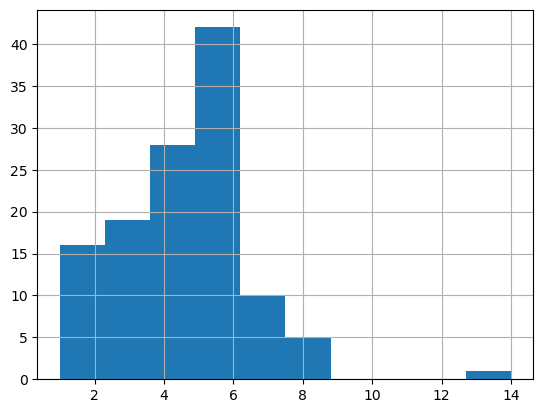

count    121.000000
mean       4.487603
std        1.911002
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       14.000000
Name: pass_result, dtype: float64 

Total number of sacks: 543


In [21]:
sacks_per_game = df_plays.groupby('game_id').pass_result.value_counts()[:,'S']
sacks_per_game.hist()
plt.show()
print(sacks_per_game.describe(), '\n')
print('Total number of sacks:', sacks_per_game.sum())

* Not every game has a sack; out of 122 - one game didn't have any successful sacks in it. 
* On average you see about 4 sacks per game - it is quite rare and valuable event for the defense team as it could turn the tide
* We have 543 total sacks to deal with (this includes non-linebackers sacks) - not the biggest number but enough to work with. 


**How many hits per game?**

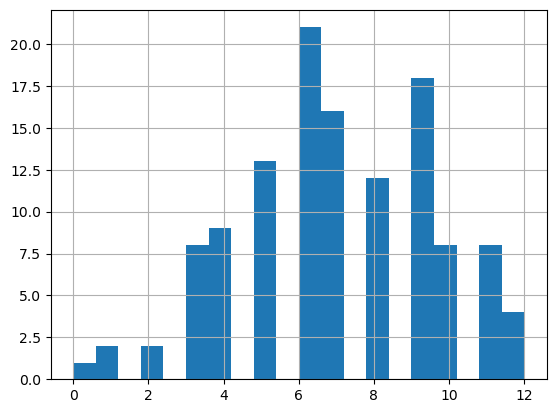

count    122.000000
mean       6.909836
std        2.628528
min        0.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       12.000000
Name: pff_hit, dtype: float64 

Total number of hits: 843.0


In [22]:
hits_per_game = df_scouting.groupby('game_id').pff_hit.sum()
hits_per_game.hist(bins=20)
plt.show()
print(hits_per_game.describe(), '\n')
print('Total number of hits:', hits_per_game.sum())

* We see that hits are not that many as well - about 7 per game on average. This could serve well as an additional performance measure.

**How many hurries per game?**

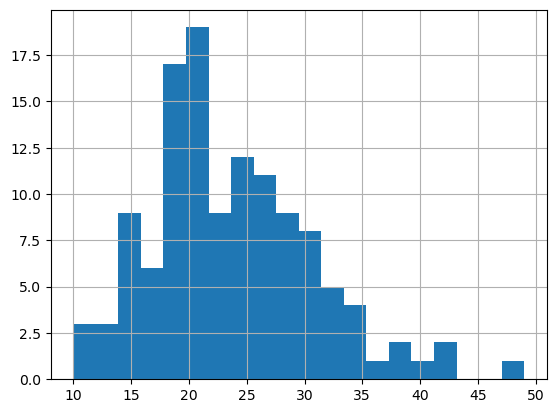

count    122.000000
mean      23.581967
std        7.285035
min       10.000000
25%       19.000000
50%       22.000000
75%       28.000000
max       49.000000
Name: pff_hurry, dtype: float64 

Total number of pass hurries: 2877.0


In [23]:
hurries_per_game = df_scouting.groupby('game_id').pff_hurry.sum()
hurries_per_game.hist(bins=20)
plt.show()
print(hurries_per_game.describe(), '\n')
print('Total number of pass hurries:', hurries_per_game.sum())

* There are a lot more hurries per game - we can add it to the performance metrics
* We will define successfull pass rush as one of the sack/hit/hurry happenning


**Defining the most successfull player?**

In [24]:
#adding success
df_scouting['success'] = 0
df_scouting.loc[(df_scouting.pff_hit > 0) | (df_scouting.pff_hurry > 0) | (df_scouting.pff_sack > 0), 'success'] = 1

In [25]:
lb_players = pd.merge(left=df_players_lb, right=df_scouting.loc[:,['nfl_id','pff_sack','pff_hurry', 'pff_hit', 'success']].groupby(['nfl_id']).sum(), left_on='nfl_id', right_on='nfl_id')

In [26]:
lb_players.sort_values('success', ascending=False).head(15)

,height,weight,birth_date,college_name,official_position,display_name,age,pff_sack,pff_hurry,pff_hit,success
nfl_id,,,,,,,,,,,
43435,6.250000,261,1992-08-15,Grand Valley State,OLB,Matt Judon,29.396908,9.0,27.0,7.0,43
41915,6.166667,250,1992-11-17,Colorado State,OLB,Shaquil Barrett,29.139544,6.0,29.0,7.0,42
46110,6.166667,250,1996-06-05,Boston College,OLB,Harold Landry,25.591217,9.0,26.0,7.0,42
47795,6.416667,277,1997-12-03,Michigan,OLB,Rashan Gary,24.096320,5.0,25.0,10.0,40
43298,6.416667,240,1992-09-08,Georgia,OLB,Leonard Floyd,29.331198,8.0,25.0,2.0,35
43292,6.416667,280,1995-07-11,Ohio State,OLB,Joey Bosa,26.494726,4.0,21.0,5.0,30
37075,6.250000,250,1989-03-26,Texas A&amp;M,OLB,Von Miller,32.786436,5.0,21.0,4.0,30
47790,6.416667,262,1997-07-13,Kentucky,OLB,Josh Allen,24.487840,5.0,16.0,5.0,26
42401,6.250000,260,1991-03-13,Missouri,OLB,Markus Golden,30.823357,5.0,14.0,5.0,24


* We see that most 'successful' players have a higher count of sacks, but some of them got on top by having higher hurry count
* We see that most of the linebackers don't do any sacks at all. (median = 0)
* The most sacks LBs have are about one per game - 8-9 number of total sacks across 8 weeks
* To add to the performance measure we will also look at the pass hurry and hit and the sum of all positive outcomes comes as 'success'

**Counting pass rushing attempts**

In [27]:
lb_players['pass_rush_attempts'] = df_scouting.groupby('nfl_id').pff_role.value_counts()[:,'Pass Rush']

In [28]:
lb_players['success_ratio'] = lb_players['success'] / lb_players['pass_rush_attempts']
lb_players.loc[(lb_players.pass_rush_attempts > 20) & (lb_players.success >20)].sort_values('success_ratio', ascending=False).head(15)

,height,weight,birth_date,college_name,official_position,display_name,age,pff_sack,pff_hurry,pff_hit,success,pass_rush_attempts,success_ratio
nfl_id,,,,,,,,,,,,,
47788,6.000000,237,1998-02-17,Louisiana State,ILB,Devin White,23.888239,0.0,14.0,9.0,23,70.0,0.328571
43435,6.250000,261,1992-08-15,Grand Valley State,OLB,Matt Judon,29.396908,9.0,27.0,7.0,43,189.0,0.227513
53441,6.250000,245,NaT,NaN,OLB,Micah Parsons,NaN,3.0,15.0,5.0,23,108.0,0.212963
47795,6.416667,277,1997-12-03,Michigan,OLB,Rashan Gary,24.096320,5.0,25.0,10.0,40,196.0,0.204082
41915,6.166667,250,1992-11-17,Colorado State,OLB,Shaquil Barrett,29.139544,6.0,29.0,7.0,42,222.0,0.189189
37075,6.250000,250,1989-03-26,Texas A&amp;M,OLB,Von Miller,32.786436,5.0,21.0,4.0,30,160.0,0.187500
38548,6.166667,247,1989-04-26,South Carolina,OLB,Melvin Ingram,32.701561,1.0,14.0,8.0,23,123.0,0.186992
46110,6.166667,250,1996-06-05,Boston College,OLB,Harold Landry,25.591217,9.0,26.0,7.0,42,225.0,0.186667
43298,6.416667,240,1992-09-08,Georgia,OLB,Leonard Floyd,29.331198,8.0,25.0,2.0,35,200.0,0.175000


* We see that most successful players in their pass rushes have one of the best `pff_sack` scores.
* The most paid linebacker in 2021 season was T.J.Watt - we see him here in our top 15 list with pretty even score between sacks,hurries and hits and success ratio ~ 14%

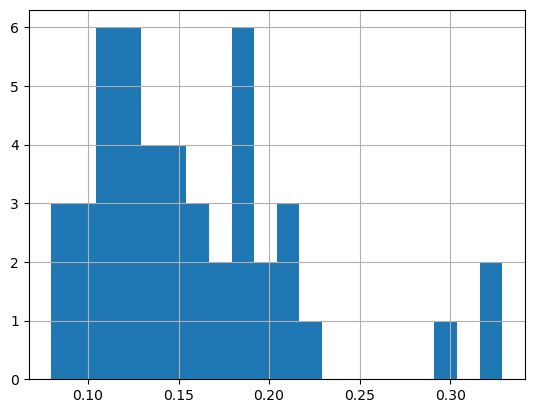

In [29]:
lb_players.loc[(lb_players.pass_rush_attempts > 10) & (lb_players.success >10), 'success_ratio'].hist(bins=20)
plt.show()

* Overall success ratio doesn't seem like a good indicator as it punishes players who try to go for a pass rush many times.
* We will focus on success and sacks and what helps linebackers make them useful on the field.

# Getting the data

* We extract the data from frame-by-frame plays for a specific player for a specific action
    * Actions that we are interested in are all pass rushes, and separately the ones ending in sacks, hurries, hits by a specific player
    * We also define a pass rush that doesn't end up with sack/hurry/hit as a failed pass rush. Even though, a specific pass rush might not be a 'fail' overall game-wise, we label it so for simplicity as we are analyzing individual performance
* To extract the needed data, we need to identify from which frame we need to start tracking - this data is encoded in the `event` column. All of the pass rushes start with a `ball_snap`. However, the plays end differently - more on that below.


**Storing sacks, hit and hurry ids for a particular player**

In [30]:
lb_pass_rushes_fail = list(df_scouting.loc[(df_scouting['nfl_id'].isin(list(lb_players.index))) & 
                (df_scouting.pff_role == 'Pass Rush') &
                (df_scouting.success == 0)].groupby('nfl_id')[['game_id', 'play_id']].value_counts().index)

lb_sacks = list(df_scouting.loc[(df_scouting['nfl_id'].isin(list(lb_players.index))) & 
                (df_scouting.pff_sack == 1)].groupby('nfl_id')[['game_id', 'play_id']].value_counts().index)

lb_hurries = list(df_scouting.loc[(df_scouting['nfl_id'].isin(list(lb_players.index))) & 
                (df_scouting.pff_hurry == 1)].groupby('nfl_id')[['game_id', 'play_id']].value_counts().index)

lb_hits = list(df_scouting.loc[(df_scouting['nfl_id'].isin(list(lb_players.index))) & 
                (df_scouting.pff_hit == 1)].groupby('nfl_id')[['game_id', 'play_id']].value_counts().index)

lb_success = list(df_scouting.loc[(df_scouting['nfl_id'].isin(list(lb_players.index))) & 
                (df_scouting.success == 1)].groupby('nfl_id')[['game_id', 'play_id']].value_counts().index)

**How does a sack look in data?**

In [31]:
df_events_sack = pd.DataFrame(index=df_week.event.value_counts().index)

i=0
for play in lb_sacks:
    
    df_events_sack = pd.concat((df_events_sack, pd.DataFrame(df_week.loc[(df_week.nfl_id == play[0]) 
                                                                 & (df_week.game_id== play[1]) 
                                                                 & (df_week.play_id== play[2])].event.value_counts())),axis=1)
    i+=1
df_events_sack = df_events_sack.T.copy()
df_events_sack.sum()

None                         11315.0
ball_snap                      217.0
pass_forward                     3.0
autoevent_ballsnap              89.0
autoevent_passforward            9.0
play_action                     53.0
run                             13.0
qb_sack                        180.0
pass_arrived                     0.0
autoevent_passinterrupted        6.0
man_in_motion                    3.0
line_set                         2.0
shift                            2.0
pass_tipped                      0.0
first_contact                   19.0
qb_strip_sack                   23.0
pass_outcome_incomplete          0.0
pass_outcome_caught              0.0
fumble                           6.0
fumble_offense_recovered         1.0
handoff                          0.0
huddle_break_offense             0.0
tackle                           0.0
penalty_flag                     0.0
lateral                          0.0
dropped_pass                     0.0
out_of_bounds                    0.0
d

* From here we know that every sack starts with a ball snap but ends differently (qb sack or qb_strip_sack mostly)
* We need this data to identify start and stop of the play

In [32]:
def form_metrics(df_week, nfl_id, game_id, play_id, players, start_event, stop_event):
    df_1  = df_week.loc[(df_week.nfl_id==nfl_id) & (df_week.game_id==game_id) & (df_week.play_id==play_id)]
    df_1_array = np.array(df_1)

    #storing items for code simplicity
    time = df_1_array[:,4]
    x = df_1_array[:,8]
    y = df_1_array[:,9]
    speed = df_1_array[:,10]
    acceleration = df_1_array[:,11]
    dist = df_1_array[:,12]
    orientation = df_1_array[:,13]
    direction = df_1_array[:,14]
    event = df_1_array[:,15]
    
    #new features
    time_delta = []
    orientation_delta = []
    direction_delta = []
    impulse = []

    #indicators
    start = 0
    stop = 0
    i = 0
    i_start = 0
    i_stop = 0

    #starting calculating from this frame (in case no start event, start from the 8th frame)
    while (start == 0) and i < len(df_1_array):
        if (event[i] in start_event) or (i+1 == 8):
            start = 1
            i_start = i
        i += 1


    while (stop == 0) and (i < len(df_1_array)):
        time_delta.append((time[i] - time[i-1]).total_seconds())
        orientation_delta.append(abs(orientation[i] - orientation[i-1]))
        direction_delta.append(abs(direction[i] - direction[i-1]))
        impulse.append(players.loc[nfl_id].weight * acceleration[i])
        if (event[i] in stop_event) or (i+1 == len(df_1_array)):
            stop = 1
            i_stop = i
            break
        i += 1
    
    temp_ = list([
        #nfl_id
        int(nfl_id),
        #game_id
        int(game_id),
        #play_id
        int(play_id),
        #total time spent
        sum(time_delta),
        #total distance travelled
        sum(dist[i_start:i_stop+1]),
        #average speed
        sum(dist[i_start:i_stop+1]) / sum(time_delta),
        #maximum speed
        max(speed[i_start:i_stop+1]),
        #maxium acceleration
        max(acceleration[i_start:i_stop+1]),
        #total rotation (orientation change)
        sum(orientation_delta),
        #rotation speed
        sum(orientation_delta) / sum(time_delta),
        #total change of direction
        sum(direction_delta),
        #change of direction speed
        sum(direction_delta) / sum(time_delta),
        max(impulse)
        
    ])
    
    return temp_

In [33]:
column_names = [
    'nfl_id',
    'game_id',
    'play_id',
    'total_time',
    'distance_traveled',
    'speed_average',
    'speed_max',
    'acceleration_max',
    'rotation_total',
    'rotation_speed',
    'direction_change_total',
    'direction_change_speed',
    'impulse_max'
]

#storing the column names for different outcomes

column_names_sacks = ['sack_' + col for col in column_names]
column_names_hits =  ['hit_' + col for col in column_names]
column_names_hurries =  ['hurry_' + col for col in column_names]
column_names_fails =  ['fail_' + col for col in column_names]
column_names_success =  ['success_' + col for col in column_names]

#### Getting sacks metrics

In [34]:
sacks_metrics = []

start_event = 'ball_snap'
stop_event = ['qb_sack','autoevent_passinterrupted','qb_strip_sack']

for play in lb_sacks:
    
    sacks_metrics.append(form_metrics(df_week,play[0],play[1],play[2], lb_players, start_event, stop_event))

df_sacks = pd.DataFrame(sacks_metrics, columns=column_names_sacks)
df_success = pd.DataFrame(sacks_metrics, columns=column_names_success)

#### How do hits looks in data?

In [35]:
df_events_hits = pd.DataFrame(index=df_week.event.value_counts().index)

i=0
for play in lb_hits:
    
    df_events_hits = pd.concat((df_events_hits, pd.DataFrame(df_week.loc[(df_week.nfl_id == play[0]) 
                                                                 & (df_week.game_id== play[1]) 
                                                                 & (df_week.play_id== play[2])].event.value_counts())),axis=1)
    i+=1
df_events_hits = df_events_hits.T.copy()
df_events_hits.sum()

None                         11380.0
ball_snap                      275.0
pass_forward                   274.0
autoevent_ballsnap             123.0
autoevent_passforward          131.0
play_action                     61.0
run                              0.0
qb_sack                          0.0
pass_arrived                     7.0
autoevent_passinterrupted        9.0
man_in_motion                    3.0
line_set                         1.0
shift                            3.0
pass_tipped                      4.0
first_contact                    3.0
qb_strip_sack                    0.0
pass_outcome_incomplete          4.0
pass_outcome_caught              0.0
fumble                           2.0
fumble_offense_recovered         2.0
handoff                          0.0
huddle_break_offense             0.0
tackle                           0.0
penalty_flag                     0.0
lateral                          0.0
dropped_pass                     0.0
out_of_bounds                    0.0
d

* We see that out of 276 cases - in all cases but one the play starts with a ball_snap and completes at pass_forward action

#### Getting hits metrics

In [36]:
hits_metrics = []

start_event = ['ball_snap'] 
stop_event = ['pass_forward','autoevent_passinterrupted']

for play in lb_hits:
    
    hits_metrics.append(form_metrics(df_week,play[0],play[1],play[2], lb_players, start_event, stop_event))

df_hits = pd.DataFrame(hits_metrics, columns=column_names_hits)
df_success = pd.concat((df_success, pd.DataFrame(hits_metrics, columns=column_names_success)))

#### How do hurries look in the data?

In [37]:
df_events_hurry = pd.DataFrame(index=df_week.event.value_counts().index)

i=0
for play in lb_hurries:
    
    df_events_hurry = pd.concat((df_events_hurry, pd.DataFrame(df_week.loc[(df_week.nfl_id == play[0]) 
                                                                 & (df_week.game_id== play[1]) 
                                                                 & (df_week.play_id== play[2])].event.value_counts())),axis=1)
    i+=1
df_events_hurry = df_events_hurry.T.copy()
df_events_hurry.sum()

None                         41978.0
ball_snap                      889.0
pass_forward                   700.0
autoevent_ballsnap             391.0
autoevent_passforward          355.0
play_action                    200.0
run                            101.0
qb_sack                         76.0
pass_arrived                    27.0
autoevent_passinterrupted       25.0
man_in_motion                   16.0
line_set                        17.0
shift                           15.0
pass_tipped                      4.0
first_contact                   23.0
qb_strip_sack                   10.0
pass_outcome_incomplete         11.0
pass_outcome_caught              0.0
fumble                           2.0
fumble_offense_recovered         0.0
handoff                          3.0
huddle_break_offense             0.0
tackle                           0.0
penalty_flag                     0.0
lateral                          0.0
dropped_pass                     0.0
out_of_bounds                    1.0
d

* Here the play starts again with a ball_snap, but ends either with a pass, run, sack or another kind of interruption

#### Getting hurries metrics

In [38]:
hurry_metrics = []

start_event = ['ball_snap'] 
stop_event = ['pass_forward','autoevent_passinterrupted', 'qb_sack', 'run', 'qb_strip_sack', 'man_in_motion']

for play in lb_hurries:
    
    hurry_metrics.append(form_metrics(df_week,play[0],play[1],play[2], lb_players, start_event, stop_event))

df_hurries = pd.DataFrame(hurry_metrics, columns=column_names_hurries)
df_success = pd.concat((df_success, pd.DataFrame(hurry_metrics, columns=column_names_success)))

#### How do unsuccessful pass rushes look in general in the data? 

* Here is a disclaimer - we call any pass rush that didn't complete as a sack, hit or hurry by that particular player a failed attempt. Even though it might not be the case in real life as that particular player carried some other function (clearing the space between linemen). We do this for the simplicity stake as we are analyzing individual performance data.

In [39]:
df_events_fails = pd.DataFrame(index=df_week.event.value_counts().index)

random.seed(1)
sample_fails = sample(lb_pass_rushes_fail,1000)


i=0
for play in sample_fails:
    
    df_events_fails = pd.concat((df_events_fails, pd.DataFrame(df_week.loc[(df_week.nfl_id == play[0]) 
                                                                 & (df_week.game_id== play[1]) 
                                                                 & (df_week.play_id== play[2])].event.value_counts())),axis=1)
    i+=1

df_events_fails = df_events_fails.T.copy()
df_events_fails.sum()

None                         38313.0
ball_snap                      995.0
pass_forward                   906.0
autoevent_ballsnap             443.0
autoevent_passforward          467.0
play_action                    181.0
run                             53.0
qb_sack                         38.0
pass_arrived                    33.0
autoevent_passinterrupted       23.0
man_in_motion                    8.0
line_set                        14.0
shift                           13.0
pass_tipped                     18.0
first_contact                    8.0
qb_strip_sack                    2.0
pass_outcome_incomplete          5.0
pass_outcome_caught              1.0
fumble                           3.0
fumble_offense_recovered         3.0
handoff                          1.0
huddle_break_offense             1.0
tackle                           1.0
penalty_flag                     0.0
lateral                          0.0
dropped_pass                     0.0
out_of_bounds                    0.0
d

* We see that in most cases unsuccessful pass rushes by a particular player end with a pass forward (90% cases), however, sometimes it ends with a qb sack or pass interruption.

#### Getting unsuccessfull pass rushes metrics

In [40]:
%%time
fails_metrics = []

start_event = ['ball_snap'] 
stop_event = ['pass_forward', 'autoevent_passforward', 'autoevent_passinterrupted', 'qb_sack', 'run', 'qb_strip_sack', 'man_in_motion', 'fumble', 'pass_tipped']

for play in lb_pass_rushes_fail:
    
    fails_metrics.append(form_metrics(df_week,play[0],play[1],play[2], lb_players, start_event, stop_event))

df_fails = pd.DataFrame(fails_metrics, columns=column_names_fails)

Wall time: 4min 47s


# Studying qb-sacks metrics

* In this section we study Quarterback Sacks in more detail and plot some linebackers movements.

In [41]:
df_sacks.describe().loc[:,['sack_total_time', 'sack_rotation_total', 'sack_rotation_speed', 'sack_direction_change_total', 'sack_direction_change_speed']]

,sack_total_time,sack_rotation_total,sack_rotation_speed,sack_direction_change_total,sack_direction_change_speed
count,217.000000,217.000000,217.000000,217.000000,217.000000
mean,4.405991,442.900553,99.711927,377.784654,81.341988
std,1.217812,337.723783,69.151365,295.782615,57.078107
min,2.000000,52.910000,20.427660,19.990000,9.086364
25%,3.600000,202.110000,46.702128,133.360000,34.418919
50%,4.200000,360.940000,77.294737,280.710000,56.215625
75%,5.000000,567.110000,137.365854,553.400000,127.410526
max,9.600000,2560.570000,493.533333,1273.340000,283.995238


**Rotation and change of direction - facts**

* Min sack time is 2 secs! Median is 4.2 seconds - this is a very fast move, though as we see later - a pass usually takes about 3 seconds. So quarterbacks need to be fast in their decision making.
* Average total rotation is 443 degrees, that means that in order to make this move on average you need to make more than a full circle around yourself at least once
* Direction change on average is about 360 degrees that means your cumulative change in direction also makes a full circle

* Looks like in order to complete this move you need to spin and zig-zag indeed.


**Speed vs change in direction?**

In [42]:
df_sacks[['sack_speed_average','sack_rotation_speed','sack_direction_change_speed', 'sack_impulse_max']].corr(method='spearman')

,sack_speed_average,sack_rotation_speed,sack_direction_change_speed,sack_impulse_max
sack_speed_average,1.000000,-0.004814,-0.272412,0.140825
sack_rotation_speed,-0.004814,1.000000,0.334006,0.163195
sack_direction_change_speed,-0.272412,0.334006,1.000000,0.277096
sack_impulse_max,0.140825,0.163195,0.277096,1.000000


* We see indeed there is a small negative correlation between change of direction speed and average speed
* This makes sense as doing zig-zag moves, you have to make small stops
* We also note slight positive correlation between rotation speed and change of direction speed

### QB sacks - some case studies

* Black arrows on the graphs point towards the orientation of a player and the length indicates the speed
* We can see that some differences in the shape of the movement of players depending on the speed vs rotation and change of direction
    - Higher speed usually means a hindered ability to change direction of movement or rotate

In [43]:
def sack_plot(nflid, gameid, playid, df_week):
    
    df_case = df_week.loc[(df_week.nfl_id==nflid) & (df_week.game_id==gameid) & (df_week.play_id==playid)][5:-2]

    plt.rcParams["figure.figsize"] = [10, 5.50]
    plt.rcParams["figure.autolayout"] = True
    point1 = [df_case.iloc[0]['x'], df_case.iloc[0]['y']]
    point2 = [df_case.iloc[-1]['x'], df_case.iloc[-1]['y']]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, 'ro', linestyle="-")
    plt.text(point1[0]-0.1, point1[1]+.5, "Start")
    plt.text(point2[0]+0.1, point2[1]+0.1, "QB Sack")

    #plotting line movements
    for i in range(1,len(df_case)):
        point1 = [df_case.iloc[i-1]['x'], df_case.iloc[i-1]['y']]
        point2 = [df_case.iloc[i]['x'], df_case.iloc[i]['y']]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, 'bo', linestyle="--")

    #plotting orientation
    for i in range(1,len(df_case)):
        point = [df_case.iloc[i-1]['x'], df_case.iloc[i-1]['y']]
        direction_x = df_case.iloc[i-1]['s'] * math.cos((-df_case.iloc[i-1]['o']+90)/180 * math.pi)
        direction_y = df_case.iloc[i-1]['s'] * math.sin((-df_case.iloc[i-1]['o']+90)/180 * math.pi)
        plt.quiver(point[0], point[1], direction_x, direction_y, angles='uv', width=0.002, minlength=0.01, scale_units = 'height', scale=50, color='black', alpha=0.9)

    plt.ylim(df_case.y.min()-3, df_case.y.max()+3)
    plt.xlim(df_case.x.min()-1, df_case.x.max()+1)

    play = df_plays.loc[(df_plays.game_id == gameid) & (df_plays.play_id == playid), ['possession_team', 'defensive_team', 'play_description']]
    plt.title(f'{play.possession_team.iloc[0]} vs {play.defensive_team.iloc[0]}, {play.play_description.iloc[0]}', fontsize = 8)
    plt.show()

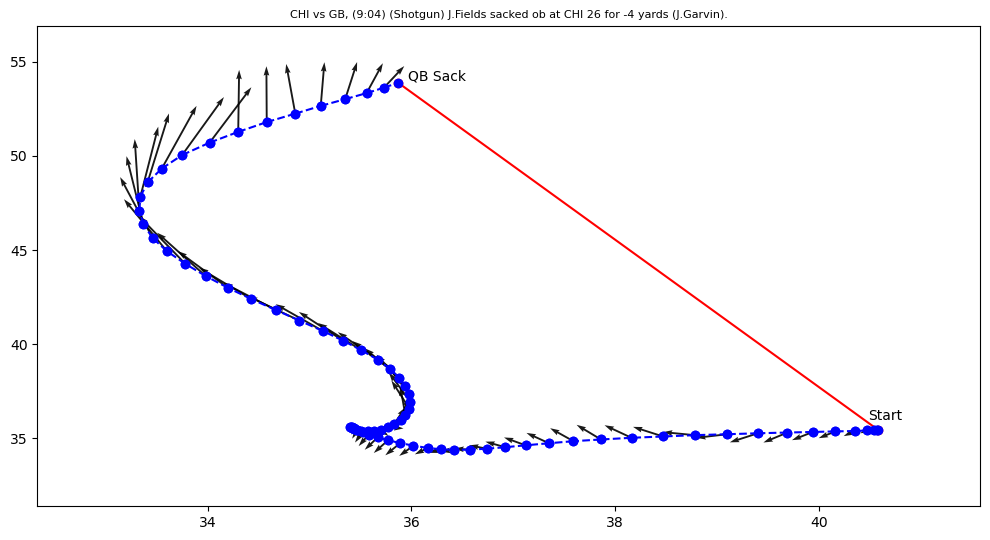

In [44]:
#random qb sack
sack_plot(52650,2021101703,1437,df_week)

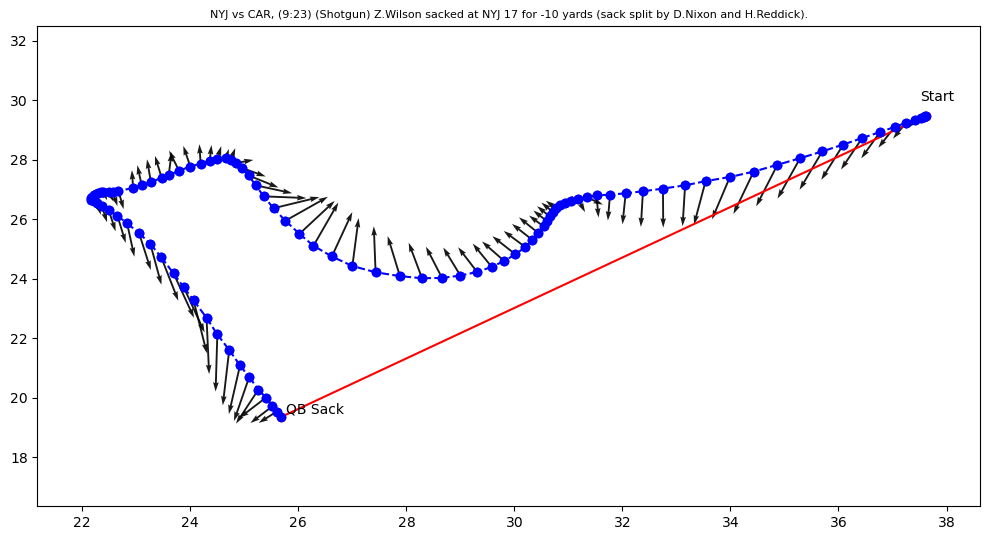

In [45]:
#max rotation total
sack_plot(44825,2021091202,2543,df_week)

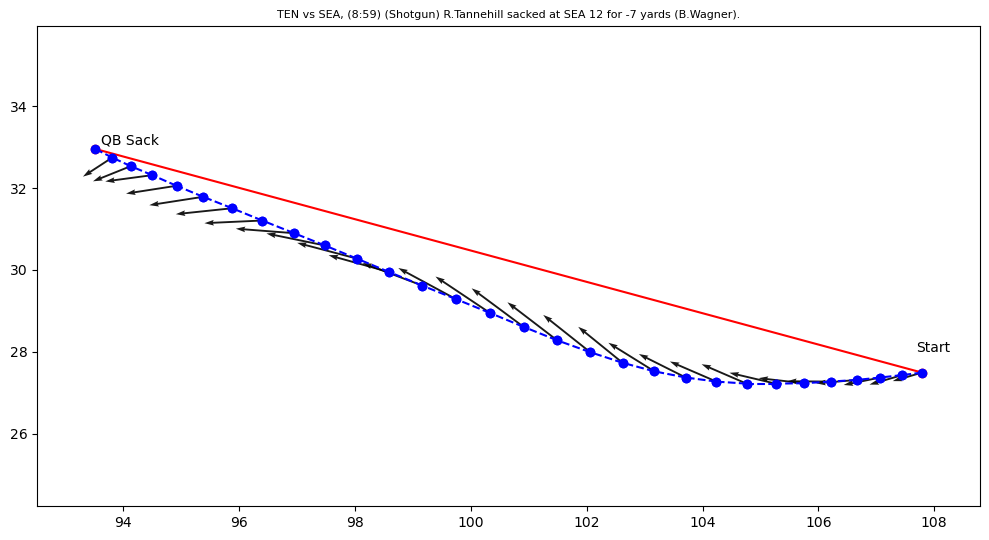

In [46]:
#max average speed 
sack_plot(38577,2021091912,1218,df_week)

* Here is the example from the beginning with S.Barret making a move vs Miami Dolphins quarterback (https://youtu.be/HtUr_MW83sA?t=85)

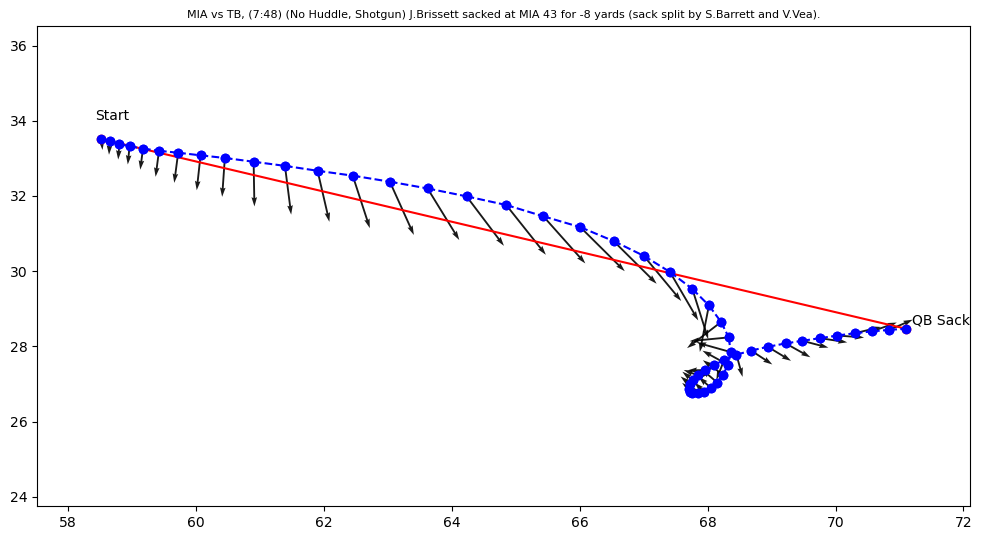

In [47]:
#S Battet
sack_plot(41915,2021101007,3697,df_week)

# Cross-data analysis

* Here we compare overall metrics for different pass rushes outcomes - sacks, hits, hurries, fails

### Comparing metrics between the outcomes (sacks, hits, hurries, unsuccessfull pass rushes)

In [48]:
df_full = pd.DataFrame()
df_full = pd.concat((df_sacks, df_hits, df_hurries, df_success, df_fails))

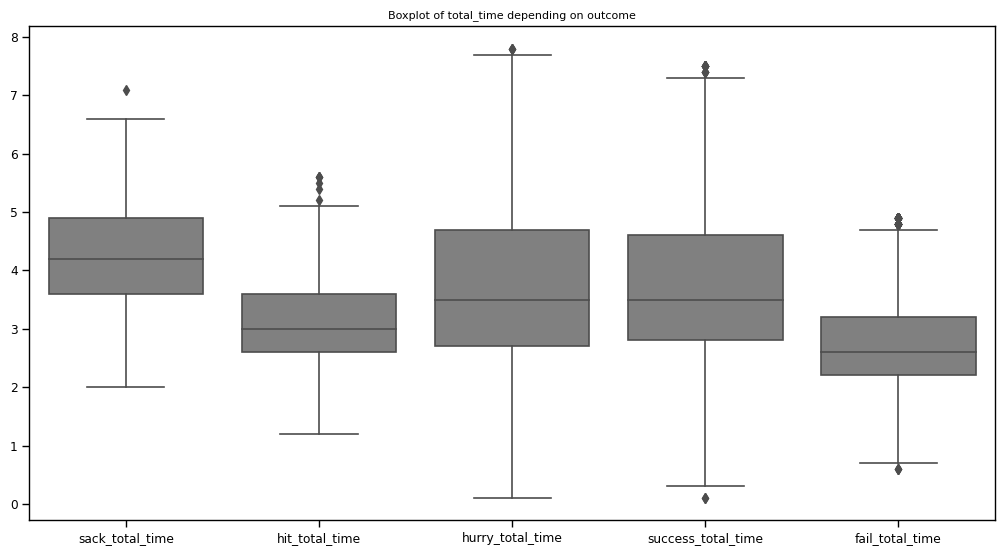

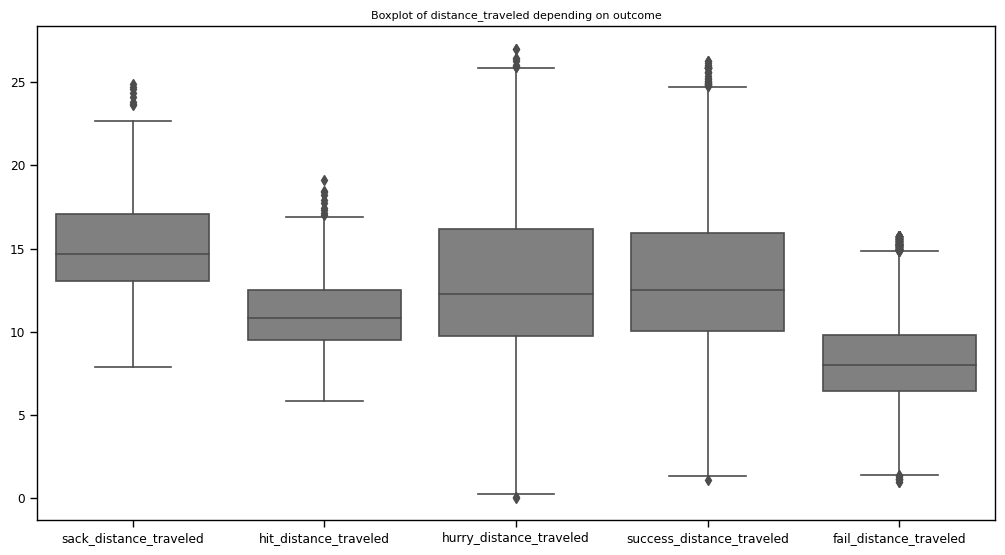

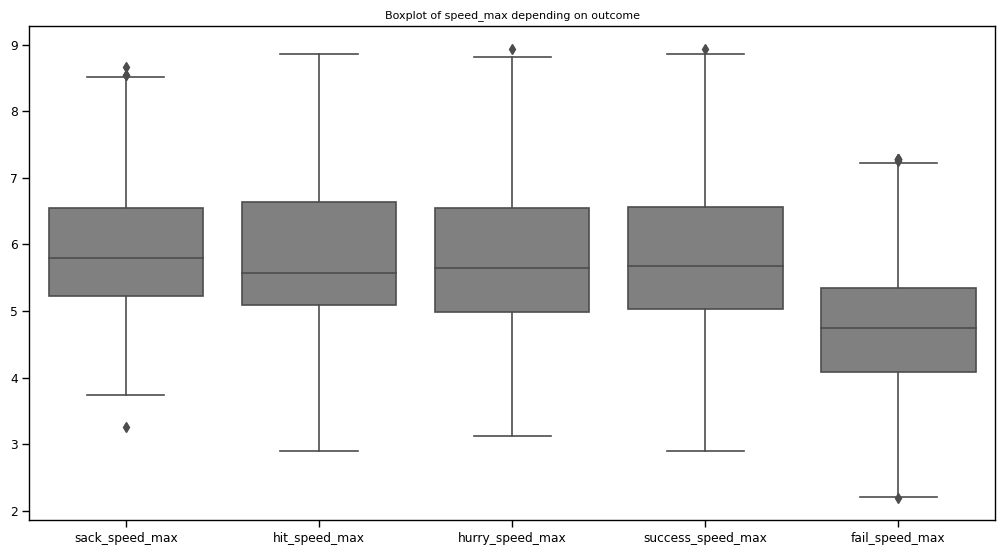

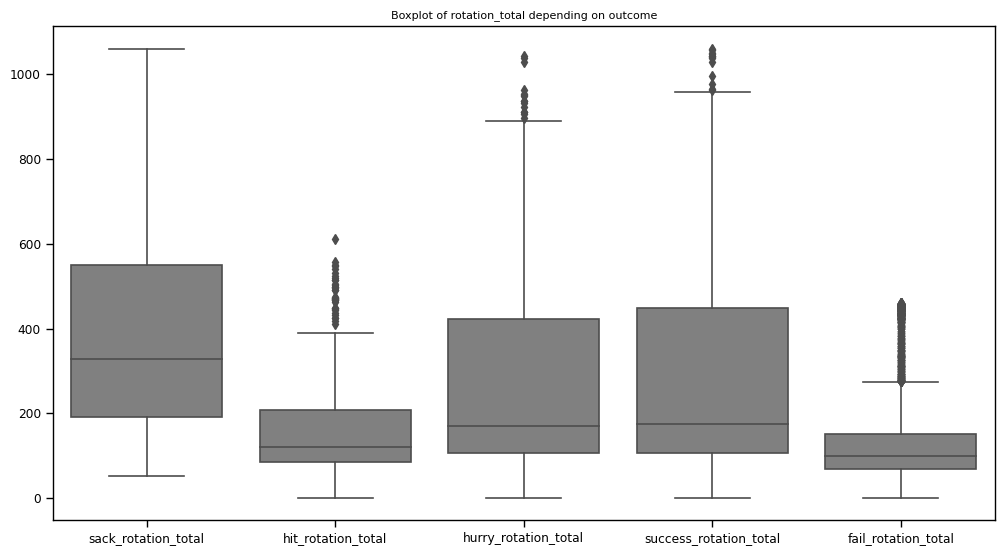

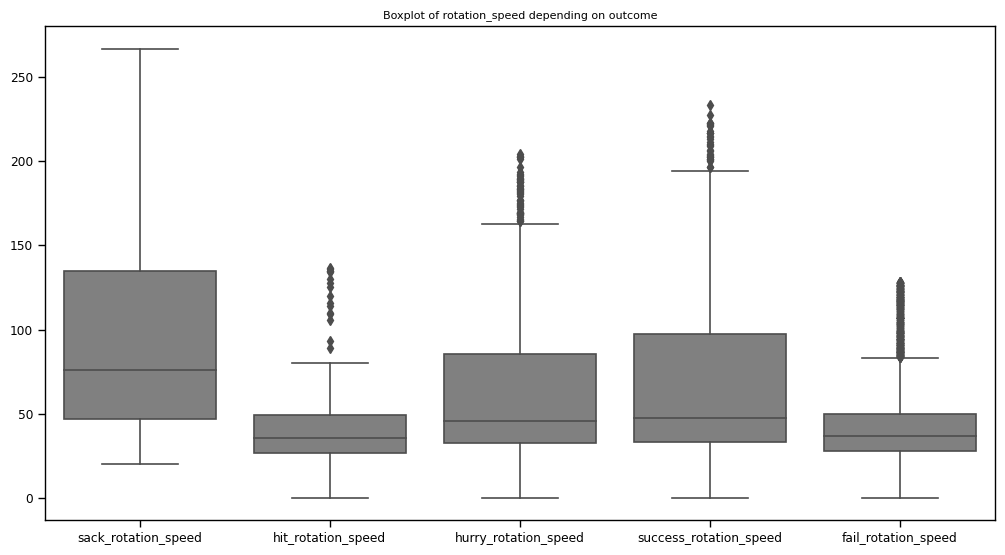

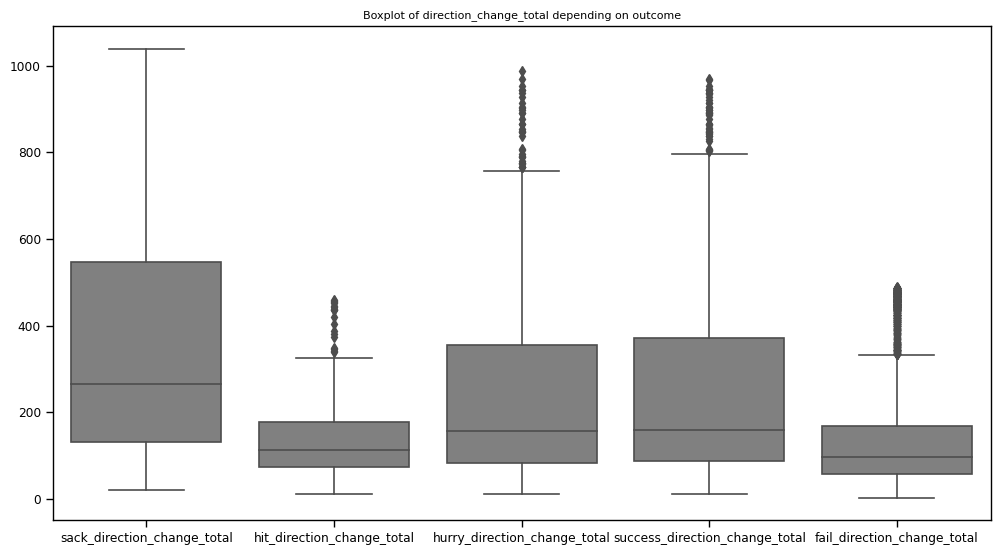

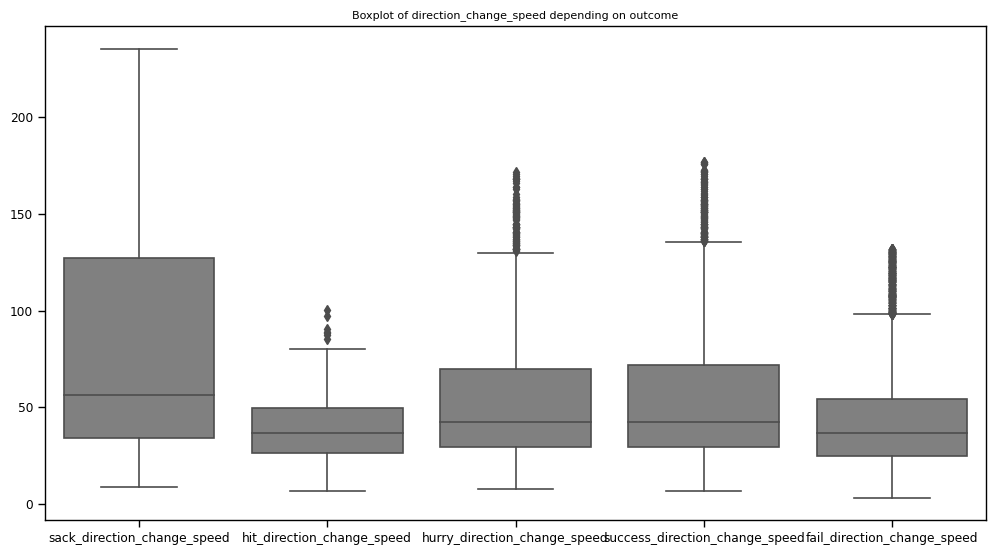

In [49]:
def iqr_ts (data, columns): #IQR function
    result = pd.DataFrame()
    for column in columns:
        data_ = data.copy()
        q1 = data_[column].quantile(0.25)
        q3 = data_[column].quantile(0.75)
        iqr = [q1-1.5*(q3-q1), q3+1.5*(q3-q1)]
        result = pd.concat((result, data_.loc[(data_[column] >= iqr[0]) & (data_[column] <= iqr[1]),:]))
    return result

column_names_1 = [
    'total_time',
    'distance_traveled',
    'speed_max',
    'rotation_total',
    'rotation_speed',
    'direction_change_total',
    'direction_change_speed'
    ]

for col in column_names_1:
    cols = ['sack_'+ col, 'hit_' + col, 'hurry_' + col,'success_'+ col, 'fail_' + col]
    sns.set_context("paper", rc={"font.size":5,"axes.titlesize":8,"axes.labelsize":8})   
    sns.boxplot(data = iqr_ts(df_full,cols)[cols], color='gray')
    plt.title(f'Boxplot of {col} depending on outcome')
    plt.show()

* `total time` - we definitely note the difference between time spent on the play with successful pass rush (i.e. sack) vs failed one. On average, a sack takes about 4.2 secs and an unsuccessful pass rush takes about 3 seconds. 
    - This means that a quarterback needs to make their moves quickly (3 seconds or less) or a linebacker has a greater chance to catch up to them
* `distance_travelled` - we here the similar picture, given that a linebacker given more time to get to the quarterback - they move further in terms of distance on average
* `rotation` - in terms of rotation (total and speed), we see the difference in the boxplots between sack and failed attempts, however, the difference is more subtle
* `direction` - same goes for direction. We do some stat tests below to see if there is a statistically significant difference.

### Stat tests for cross-data analysis
* We do some Mann-Whitneyu stat test below

***Rotation total***

**Mann-Whitney U Test (successful and failed pass rushes have equal distribution)**

* H0: the distributions of **success rotation total** and **fail rotation total** are equal
* H1: the distributions of both samples are not equal.

In [50]:
print(f'Success rotation total mean = {df_full.success_rotation_total.mean():.2f}')
print(f'Failed pass rush rotation total mean = {df_full.fail_rotation_total.mean():.2f}')
data1 = df_full.success_rotation_total.dropna()
data2 = df_full.fail_rotation_total.dropna()
stat, p = mannwhitneyu(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

Success rotation total mean = 324.82
Failed pass rush rotation total mean = 213.80
stat=7245060.500, p=0.000
Probably different distributions


***Change in direction total***

**Mann-Whitney U Test (successful and failed pass rushes have equal distribution)**

* H0: the distributions of **success change in direction total** and **fail change in direction total** are equal
* H1: the distributions of both samples are not equal.

In [51]:
print(f'Success change in direction total mean = {df_full.success_direction_change_total.mean():.2f}')
print(f'Failed pass rush change in direction total mean = {df_full.fail_direction_change_total.mean():.2f}')
data1 = df_full.success_direction_change_total.dropna()
data2 = df_full.fail_direction_change_total.dropna()
stat, p = mannwhitneyu(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

Success change in direction total mean = 284.68
Failed pass rush change in direction total mean = 202.02
stat=6807372.500, p=0.000
Probably different distributions


***Speed average***

**Mann-Whitney U Test (successful and failed pass rushes have equal distribution)**

* H0: the distributions of **success average speed** and **fail average speed** are equal
* H1: the distributions of both samples are not equal.

In [52]:
print(f'Success average speed mean = {df_full.success_speed_average.mean():.2f}')
print(f'Failed pass rush average speed mean = {df_full.fail_speed_average.mean():.2f}')
data1 = df_full.success_speed_average.dropna()
data2 = df_full.fail_speed_average.dropna()
stat, p = mannwhitneyu(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

Success average speed mean = 3.72
Failed pass rush average speed mean = 3.06
stat=8152401.500, p=0.000
Probably different distributions


### Results from cross-data analysis

* We found out that in successful pass-rushes which include sacks, hits and hurries almost all of the metrics are statistically higher
    * This importantly includes rotation and rotation speed, change in direction and change in direction speed
* And so in order to complete a successful pass rush a linebacker needs to move faster, rotate more, be able to change direction more than in their average pass rushes
* Now we study the players' metrics

# Linebackers metrics analysis

* We analyze the players' metrics and try to answer the question - what makes the best linebackers the best.


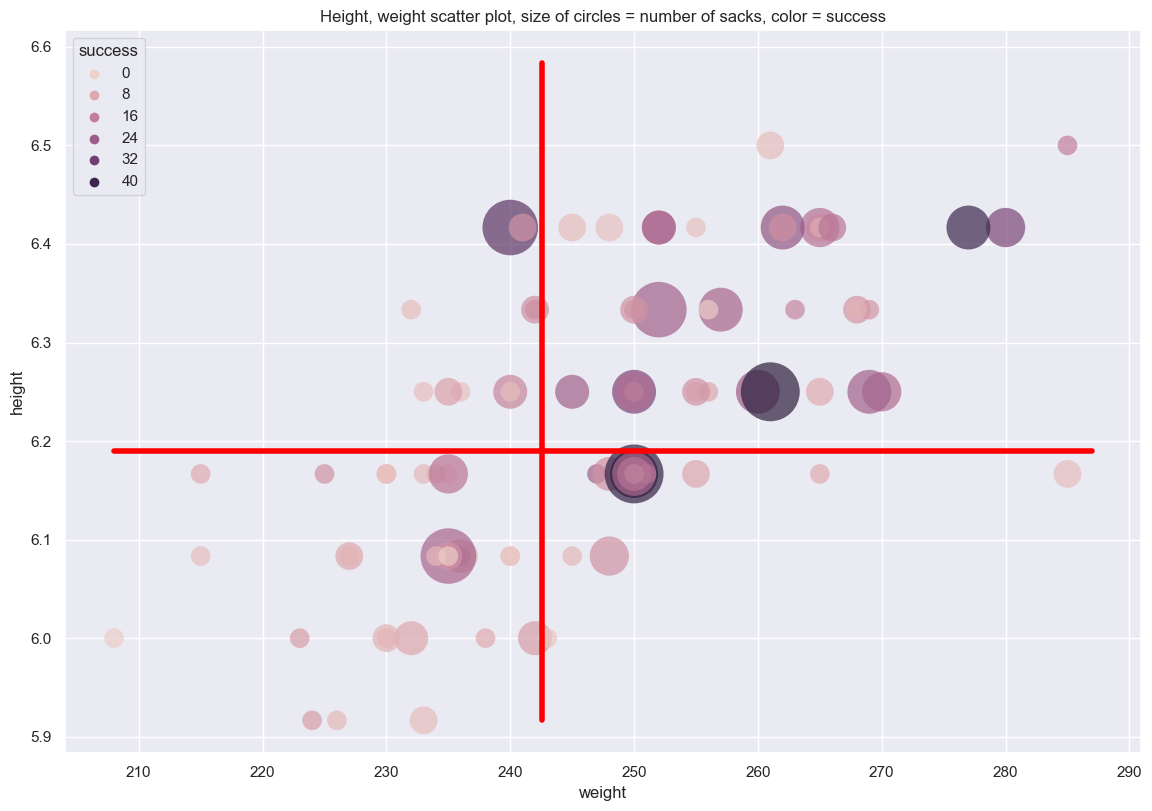

In [53]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(y=lb_players['height'], 
                x=lb_players['weight'], 
                s=lb_players['pff_sack']*200,
                hue=lb_players['success'],
               alpha=0.7)

plt.plot([lb_players['weight'].mean(), lb_players['weight'].mean()], [lb_players['height'].min(), lb_players['height'].max()], linewidth=4, color='red' )
plt.plot([lb_players['weight'].min(), lb_players['weight'].max()], [lb_players['height'].mean(), lb_players['height'].mean()], linewidth=4, color='red' )
plt.title('Height, weight scatter plot, size of circles = number of sacks, color = success')
plt.show()

**Size matters**
* Size of players definitely matters - we see that in the upper right quadrant (bigger players) there are larger and darker circles
* On the figure - bigger and darker circles are better

In [54]:
col = ['sack', 'hit', 'hurry', 'success', 'fail']

lb_players_metrics = lb_players.copy()

for c in col:
    lb_players_metrics = pd.merge(left=lb_players_metrics, left_index=True, right=df_full.groupby(c+'_nfl_id')[[c+'_total_time', 
        c+'_distance_traveled',c+'_speed_average',c+'_speed_max',c+'_acceleration_max',
        c+'_rotation_total', c+'_rotation_speed',c+'_direction_change_total', 
        c+'_direction_change_speed', c+'_impulse_max']].median(), right_index=True)

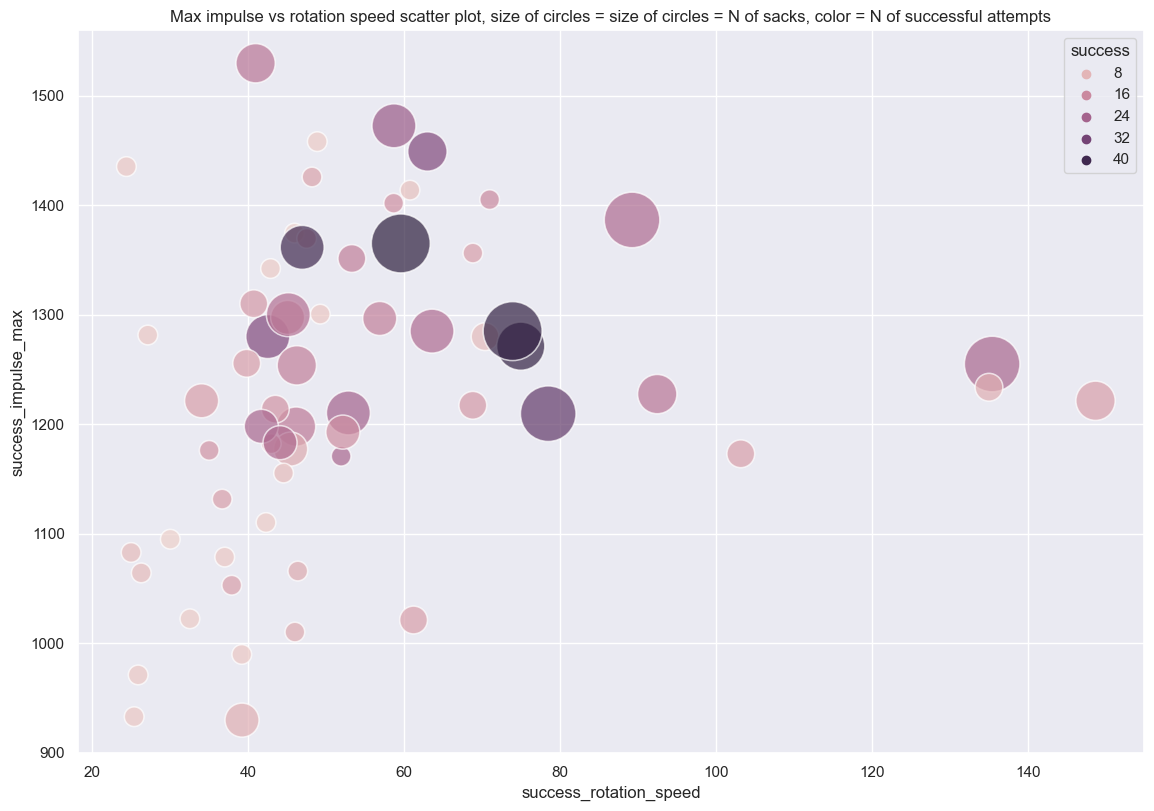

In [55]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(y=lb_players_metrics['success_impulse_max'], 
                x=lb_players_metrics['success_rotation_speed'], 
                s=lb_players_metrics['pff_sack']*200,
                hue=lb_players_metrics['success'],
               alpha=0.7)
plt.title('Max impulse vs rotation speed scatter plot, size of circles = size of circles = N of sacks, color = N of successful attempts')
plt.show()
plt.show()

* Better performing players are those who chan generate a good amount force (impulse = weight * acceleration) and able to demonstrate a good rotational movement during their plays

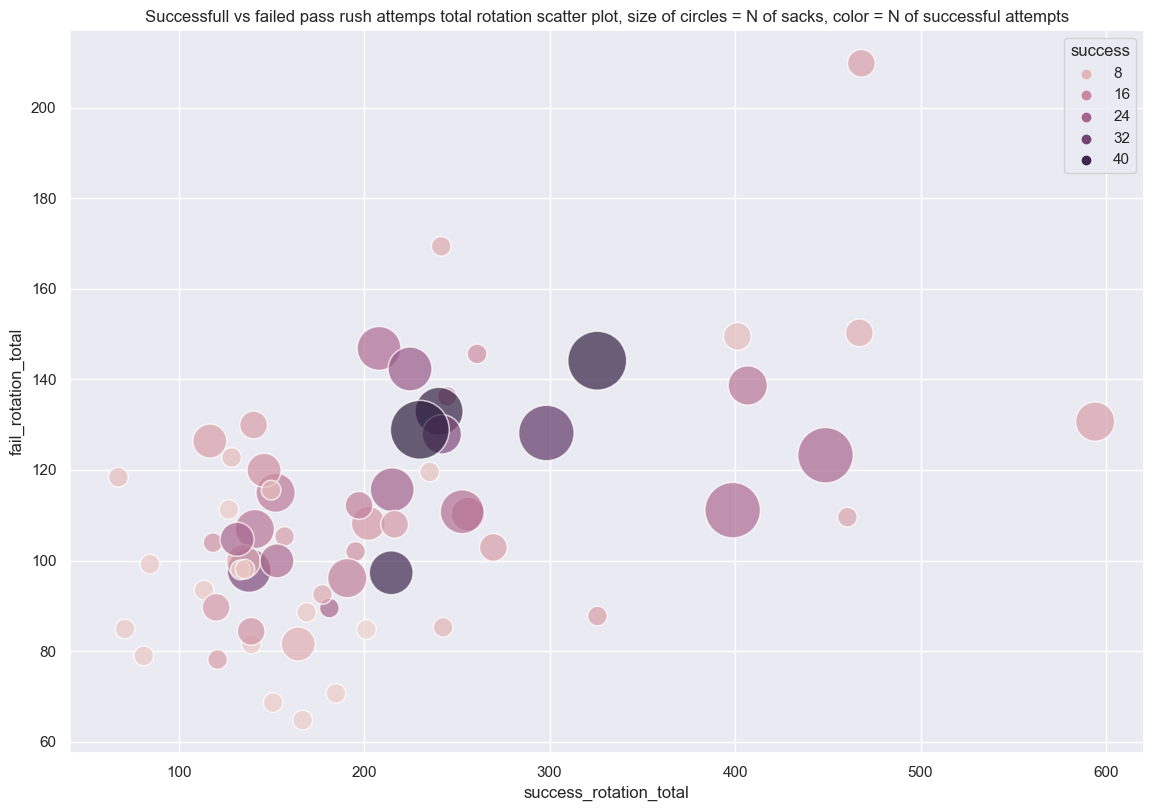

In [56]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(y=lb_players_metrics['fail_rotation_total'], 
                x=lb_players_metrics['success_rotation_total'], 
                s=lb_players_metrics['pff_sack']*200,
                hue=lb_players_metrics['success'],
               alpha=0.7)
plt.title('Successfull vs failed pass rush attemps total rotation scatter plot, size of circles = N of sacks, color = N of successful attempts')
plt.show()
plt.show()

*  We see that players who demonstrate better rotational movements in their pass rushes attempts are on average more successful in completing their plays.

## Correlation tests

***Sacks: change of direction speed***

**Spearman correlation test**

* H0: number of sacks and **change in direction speed** are independent
* H1: there is a dependency between the samples.

In [57]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['pff_sack']['sack_direction_change_speed']
print(f'Correlation between number of sacks and change in direction speed = {cor_:.2f}')
data1 = lb_players_metrics.pff_sack
data2 = lb_players_metrics.sack_direction_change_speed
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of sacks and change in direction speed = 0.09
stat=0.185, p=0.143
Cannot reject H0


***Success(sacks,hurries,hits): change of direction speed***

**Spearman correlation test**

* H0: number of successful attempts and **change in direction speed** are independent
* H1: there is a dependency between the samples.

In [58]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['success']['success_direction_change_speed']
print(f'Correlation between number of successfull attempts and change in direction speed = {cor_:.2f}')
data1 = lb_players_metrics.success
data2 = lb_players_metrics.success_direction_change_speed
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of successfull attempts and change in direction speed = 0.07
stat=0.117, p=0.356
Cannot reject H0


* Cannot reject independence on level of 0.05%
* Change of direction might not be that significant of a factor in completing a quarterback sack or hit/hurry

***Sacks: rotation speed***

**Spearman correlation test**

* H0: number of sacks and **rotation speed** are independent
* H1: there is a dependency between the samples.

In [59]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['pff_sack']['sack_rotation_speed']
print(f'Correlation between number of sacks and rotation speed = {cor_:.2f}')
data1 = lb_players_metrics.pff_sack
data2 = lb_players_metrics.sack_rotation_speed
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of sacks and rotation speed = 0.01
stat=0.248, p=0.048
Reject H0


***Success(sacks,hurries,hits): rotation speed***

**Spearman correlation test**

* H0: number of successful attempts and **rotation speed** are independent
* H1: there is a dependency between the samples.

In [60]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['success']['success_rotation_speed']
print(f'Correlation between number of successful attempts and rotation speed = {cor_:.2f}')
data1 = lb_players_metrics.success
data2 = lb_players_metrics.success_rotation_speed
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of successful attempts and rotation speed = 0.29
stat=0.490, p=0.000
Reject H0


* **Spin to win!** 
    * The test shows that we can reject non-dependency of number sacks and rotation speed at 0.05% level! And there is a stronger correlation between rotation and number of successful attempts.


***Success: weight***

**Spearman correlation test**

* H0: number of successful attempts and **weight** are independent
* H1: there is a dependency between the samples.

In [61]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['success']['weight']
print(f'Correlation between number of successful atempts and weight = {cor_:.2f}')
data1 = lb_players_metrics.success
data2 = lb_players_metrics.weight
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of successful atempts and weight = 0.39
stat=0.433, p=0.000
Reject H0


***Success: height***

**Spearman correlation test**

* H0: number of successful attempts and **height** are independent
* H1: there is a dependency between the samples.

In [62]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['success']['height']
print(f'Correlation between number of successful atempts and height = {cor_:.2f}')
data1 = lb_players_metrics.success
data2 = lb_players_metrics.height
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of successful atempts and height = 0.31
stat=0.364, p=0.003
Reject H0


* Bigger (in weight or height) players statistically do better in terms of sacks, hits and hurries

***Success: speed max***

**Spearman correlation test**

* H0: number of successful attempts and **speed** are independent
* H1: there is a dependency between the samples.

In [63]:
# Spearman's Rank Correlation Test
cor_ = lb_players_metrics.corr()['success']['success_speed_max']
print(f'Correlation between number of successful atempts and max speed = {cor_:.2f}')
data1 = lb_players_metrics.success
data2 = lb_players_metrics.success_speed_max
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Cannot reject H0')
else:
 print('Reject H0')

Correlation between number of successful atempts and max speed = -0.25
stat=-0.225, p=0.074
Cannot reject H0


* What's interesting is that both average speed and max speed have negative relationships with number of sacks, hurries and hits. Though, the relationship is not statistically significant at 0.05 level. 

### Results from players data analysis

* **Bigger - better**: `height` and `weight` - we find stronger positive relationships between number of successful pass rush attempts and size of the players
* **Spin to win!** - we find a statistically significant positive correlation between rotational metrics (`rotation total` and `rotation speed`) and number of successful attempts
* **Force matters**: we see that `acceleration` is more important than speed. Moreover, the ability to generate the force and apply it in the front line remains crucial to success. Force we define here as impulse, that's the product of `acceleration` and `weight`.
* **Speed doesn't matter**: we don't find a statistically significant relationship between `speed` and success of the players. We note that while doing their plays to get to the quarterback a linebacker has to choose between speed and change of direction/rotational movement. Though speed remains important but not significant of a factor.
* **Change of direction** :  we don't find a statistically significant correlation between `change of direction` and success of the players.




# Overall results

* In this research we try to answer the question - **What makes the best linebackers the best?**:
    * We analyzed all of the pass rushes of linebackers and defined success as a completed pass rush with a sack, hit or hurry.
    * We studied linebackers movements, extracted data, engineered additional metrics such as change of direction total during the play / speed, rotation total / speed.


* While studying a player's movement we find anecdotal evidence in the matter of shapes of the movements, that there might be a trade-off depending on the speed vs rotation and change of direction. As higher speed usually means a more of straight-line movement and less of unpredictable, wiggly, zig-zag movements:
    * Though in statistical analysis later we don't find a statistically significant relationships between successful attempts and `speed` as players rely mostly on `rotation`.
    
    
* From cross-data analysis we found that  in order to complete a successful pass rush a linebacker needs to move faster, rotate more, be able to change direction more than in their average pass rushes with almost all of the metrics being statistically higher (speed, acceleration, force), including:
    * **Rotation**: in successful attempts a linebacker **rotates** about 320 degrees (442 degrees during sacks) on average vs failed attempts' 214 degrees.
    * **Change in direction**: in successful attempts total is about 285 degrees (377 degrees during sacks) vs failed attempts' 207 degrees.
        
        
* **From player specific data we found that the best linebackers are able to generate enough momentum (*force* defined as product of `weight` and `acceleration`) as well as demonstrate better `rotational movements` than their colleagues on this position**


**Outcome and further research**:
* **For coaches:** coaches might want to include more exercise involving spinning and rotating to their drills
* **For scouts:** the bigger players are better but also one need to see how quick they are on their feet and able to move around the defense line demonstrating rotation movements
* **Further research:** further research might include a larger database to incorporate more data on sacks, hits and hurries. Also similar research could be done for different types of positions
